In [1]:
from __future__ import print_function

from keras.models import  Model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from time import time

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager


class Layer(object):
    def __init__(self, units=128, activation='relu', dropout=0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2

    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)

    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation

    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout

    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)

    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()

    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True

    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)

    def random_layer(self):
        units = np.random.randint(0, self.units_lim)
        act = random.choice(self.posible_activations)
        drop = np.random.rand()
        return Layer(units, act, drop)

    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units, self.activation, self.dropout)


class Cromosome(object):

    def __init__(self, layers=[], fit=None):
        assert type(layers) == list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        self.fit = None
        self.evaluator = Fitness.get_instance()

    def set_fitness(self, fit):
        self.evaluator = fit

    def random_indiv(self):
        n_layers = np.random.randint(0, self.max_layers)
        layers = [Layer().random_layer() for i in range(n_layers)]
        return Cromosome(layers)

    @staticmethod
    def simple_indiv():
        return Cromosome([Layer()])

    def cross(self, other_cromosome):
        new_layers = []

        if self.n_layers == 0:
            return other_cromosome

        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i < n_intersection or i >= other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)

    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers < self.max_layers:
            self.layers.append(Layer().random_layer())
            self.n_layers = len(self.layers)

    def equals(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True

    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep

    def fitness(self):
        if self.fit is None:
            self.fit = self.evaluator.calc(self)
        return self.fit


class Fitness:
    __instance = None

    @staticmethod
    def get_instance():
        """ Static access method. """
        if Fitness.__instance == None:
            Fitness()
        return Fitness.__instance

    def __init__(self):
        """ Virtually private constructor. """
        if Fitness.__instance != None:
            raise Exception("This class is a singleton!")
        else:
            Fitness.__instance = self

    def set_params(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateau=True, verbose=1):
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateau
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.num_clases = self.y_train.shape[1]
        self.callbacks = []
        if self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=self.verb))
        return self

    def calc(self, chromosome):
        model = self.decode(chromosome)
        h = model.fit(self.x_train, self.y_train,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      verbose=self.verb,
                      validation_data=(self.x_val, self.y_val),
                      callbacks=self.callbacks)
        score = model.evaluate(self.x_val, self.y_val, verbose=0)
        score_t = model.evaluate(self.x_test, self.y_test, verbose=0)
        if self.verb:
            print('Val loss: %0.4f, Test loss: %0.4f' % (score[0], score_t[0]))
            print('Val accuracy: %0.4f, Test accuracy: %0.4f' % (score[1], score_t[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        return score[1]

    def decode(self, chromosome):

        inp = Input(shape=(28, 28, 1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        return model

    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s' % metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()

    def calc_mean(self, chromosome, iters=5):
        f = []
        ti = time()
        for i in range(iters):
            f.append(self.calc(chromosome))
        print("Acc: %0.3f" % np.mean(f), np.std(f), np.max(f))
        print("Time elapsed: %0.3f" % (time() - ti))

Using TensorFlow backend.


In [2]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])
clases = [4, 9]
dm = DataManager(clases=clases)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False)

fitness.calc_mean(c)
fitness.calc_mean(Cromosome([]))


ps = [RandomParentSelector(), LinealOrder(), WheelSelection(), TournamentSelection(5)]
p = ps[2]

ti_all = time()
generational = GenerationalGA(num_parents=0.5, chromosome=c, parent_selector=p, generations=40, num_population=15, crossover_prob=0.5,
                 mutation_prob=0.7, maximize_fitness=True)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
fitness.calc_mean(winner)

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
Acc: 0.990 0.0006887696824616896 0.9910979229497323
Time elapsed: 105.218
Acc: 0.974 0.0004323034772015727 0.9749894023901732
Time elapsed: 152.095
Generic algorith params:
Number of generations: 40
Population size: 2
num parents: 1
offspring size: 1
1) best fit: 0.989


KeyboardInterrupt: 

In [14]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

In [84]:
l1 = Layer(10, 'relu', 0.1)
l2 = Layer(20, 'elu', 0.2)
l3 = Layer(30, 'prelu', 0.3)

c1 = Cromosome([l1])
c2 = Cromosome([l2])
c3 = Cromosome([l3])
c12 = Cromosome([l1, l2])
c21 = Cromosome([l2, l1])
c13 = Cromosome([l1, l3])
c31 = Cromosome([l3, l1])
c23 = Cromosome([l2, l3])
c32 = Cromosome([l3, l2])
c123 = Cromosome([l1, l2, l3])
c132 = Cromosome([l1, l3, l2])
c213 = Cromosome([l2, l1, l3])
c231 = Cromosome([l2, l3, l1])
c312 = Cromosome([l3, l1, l2])
c321 = Cromosome([l3, l2, l1])

F = Fitness_str(c321)

population = [c1, c2, c3, c12, c21, c13, c31, c23, c32, c123, c132, c213, c231, c312, c321]
for c in population:
    c.set_fitness(F)
    
population = population[:10]
_=[print(a.fitness(), end=' ') for a in population]
print('\n', F.crom)
print(c321.fitness())

-64 -65 -49 -63 -63 -63 -38 -52 -25 -50 
 0 - U:30|A:prelu|D:0.300 
1 - U:20|A:elu|D:0.200 
2 - U:10|A:relu|D:0.100 

0


In [85]:
r = RandomParentSelector(num_offspring=3, history_fitness={}, maximize_fit=True)
next_generation, all_parents = r.next_gen(population)

In [86]:
print(type(next_generation), len(next_generation), type(all_parents), len(all_parents))
print(next_generation[0], next_generation[0].fitness())
print(all_parents[0][0], all_parents[0][0].fitness())
print(all_parents[0][1], all_parents[0][1].fitness())

<class 'list'> 3 <class 'list'> 3
0 - U:10|A:relu|D:0.100 
1 - U:77|A:elu|D:0.023 
 -30
0 - U:10|A:relu|D:0.100 
1 - U:30|A:prelu|D:0.300 
 -63
0 - U:20|A:elu|D:0.200 
1 - U:30|A:prelu|D:0.300 
 -52


In [87]:
new_pop = r.replace(population, next_generation, all_parents)

In [99]:
for a , b in zip(new_pop, population):
    print(b)

0 - U:10|A:relu|D:0.100 

0 - U:20|A:elu|D:0.200 

0 - U:30|A:prelu|D:0.300 

0 - U:10|A:relu|D:0.100 
1 - U:20|A:elu|D:0.200 

0 - U:20|A:elu|D:0.200 
1 - U:10|A:relu|D:0.100 

0 - U:10|A:relu|D:0.100 
1 - U:30|A:prelu|D:0.300 

0 - U:30|A:prelu|D:0.300 
1 - U:10|A:relu|D:0.100 

0 - U:20|A:elu|D:0.200 
1 - U:30|A:prelu|D:0.300 

0 - U:30|A:prelu|D:0.300 
1 - U:20|A:elu|D:0.200 

0 - U:10|A:relu|D:0.100 
1 - U:20|A:elu|D:0.200 
2 - U:30|A:prelu|D:0.300 



In [11]:
class printer:
    def prt(self, objecto):
        print(objecto)
        return
        
class A(object):
    def __init__(self, name, printer):
        self.printer = printer
        self.name = name
        
    def self_print(self):
        self.printer.prt(self)
        
    def __repr__(self):
        return self.name

In [12]:
p = printer()
p.prt('hi')

a = A('wolo', p)

hi


In [13]:
a.self_print()

wolo


In [53]:



class chrom:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
        self.mut_prob = 0.2
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit

Generic algorith params:
Number of generations: 1000
Population size: 12
num parents: 6
offspring size: 6
1) best fit: -8.898
101) best fit: -18.555
201) best fit: -18.555
301) best fit: -18.555
401) best fit: -18.555
501) best fit: -18.555
601) best fit: -18.555
701) best fit: -18.555
801) best fit: -18.555
901) best fit: -18.555
1001) best fit: -18.555
Best Gen ->  (9.039, 8.668)
With Fitness: -18.555


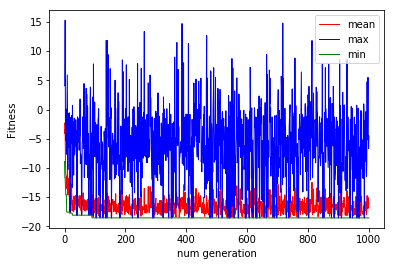

-18.554709647834812


In [66]:
pop_size = 12
mut_prob = 0.2
generations = 1000
num_parents = 0.5

c = chrom()
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False)

winner, best_fit, ranking = generational.evolve()
print(best_fit)

-18.554716504097726 19.861786404025292


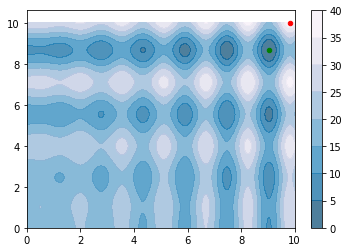

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='g', label='min', s=20)
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

In [41]:
min_z = np.argmin(z)
print(X.shape, z.shape)

(100, 100) (100, 100)


In [42]:
z[min_z]

IndexError: index 8689 is out of bounds for axis 0 with size 100

In [43]:
a= [(1,2), (2,3), (3,4)]
for i,k in a:
    print(i,k)

1 2
2 3
3 4
